In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score,train_test_split
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid

In [2]:
# data path
data = pd.read_csv("../../datafile/SY_POINT_MERGES.csv")
data

,Unnamed: 0,X,Y,pre_2022_mean_Band_1,tmp_2022_mean_Band_1,SY_ASP_5_Band_1,SY_SLOP_5_Band_1,SY_DEM_5_Band_1,DLMC,PH
0,1,107.140420,28.454940,873.166687,142.083328,311.184540,6.067848,1222.400024,旱地,4.78
1,2,107.004920,28.233230,837.500000,137.250000,41.932869,11.214284,1240.599976,旱地,4.34
2,3,107.427614,28.222543,857.833313,151.166672,325.007690,6.959332,992.099976,水田,5.83
3,4,107.063560,27.856010,807.666687,157.416672,315.000000,3.237762,908.099976,水田,7.30
4,5,107.000850,28.187500,820.416687,151.166672,309.806030,17.349291,992.799988,旱地,4.12
...,...,...,...,...,...,...,...,...,...,...
7487,7489,107.449278,28.010001,849.500000,144.666672,341.567383,5.419226,1078.599976,设施农用�?6.3,NaN
7488,7490,107.452550,28.054348,846.750000,150.166672,121.263115,9.301414,911.599976,旱地,6.90
7489,7491,107.452868,28.070184,843.000000,152.416672,122.242317,21.019365,825.700012,水田,7.03
7490,7492,107.453977,28.088211,848.250000,151.416672,101.886757,5.544981,877.000000,水田,7.25


In [3]:
data.columns

Index(['Unnamed: 0', 'X', 'Y', 'pre_2022_mean_Band_1', 'tmp_2022_mean_Band_1',
       'SY_ASP_5_Band_1', 'SY_SLOP_5_Band_1', 'SY_DEM_5_Band_1', 'DLMC', 'PH'],
      dtype='object')

In [4]:
data.rename(columns={"pre_2022_mean_Band_1":"pre","tmp_2022_mean_Band_1":"tmp","SY_ASP_5_Band_1":"asp","SY_SLOP_5_Band_1":"slope","SY_DEM_5_Band_1":"dem","DLMC":"dl"},inplace=True)
data

,Unnamed: 0,X,Y,pre,tmp,asp,slope,dem,dl,PH
0,1,107.140420,28.454940,873.166687,142.083328,311.184540,6.067848,1222.400024,旱地,4.78
1,2,107.004920,28.233230,837.500000,137.250000,41.932869,11.214284,1240.599976,旱地,4.34
2,3,107.427614,28.222543,857.833313,151.166672,325.007690,6.959332,992.099976,水田,5.83
3,4,107.063560,27.856010,807.666687,157.416672,315.000000,3.237762,908.099976,水田,7.30
4,5,107.000850,28.187500,820.416687,151.166672,309.806030,17.349291,992.799988,旱地,4.12
...,...,...,...,...,...,...,...,...,...,...
7487,7489,107.449278,28.010001,849.500000,144.666672,341.567383,5.419226,1078.599976,设施农用�?6.3,NaN
7488,7490,107.452550,28.054348,846.750000,150.166672,121.263115,9.301414,911.599976,旱地,6.90
7489,7491,107.452868,28.070184,843.000000,152.416672,122.242317,21.019365,825.700012,水田,7.03
7490,7492,107.453977,28.088211,848.250000,151.416672,101.886757,5.544981,877.000000,水田,7.25


In [5]:
# 删除缺失值
# 删除有缺失值的行
data.dropna(inplace=True)
missing_values = data.isnull().sum()
missing_values

Unnamed: 0    0
X             0
Y             0
pre           0
tmp           0
asp           0
slope         0
dem           0
dl            0
PH            0
dtype: int64

In [15]:
# 划分数据
le =LabelEncoder()
data['dl'] = le.fit_transform(data['dl'])

X = data[['pre','tmp','asp','slope','dem','dl','X','Y']]

y = data['PH']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.6,random_state=42)
X,y
len(X_train),len(X_test),len(y_train),len(y_test)

(2986, 4479, 2986, 4479)

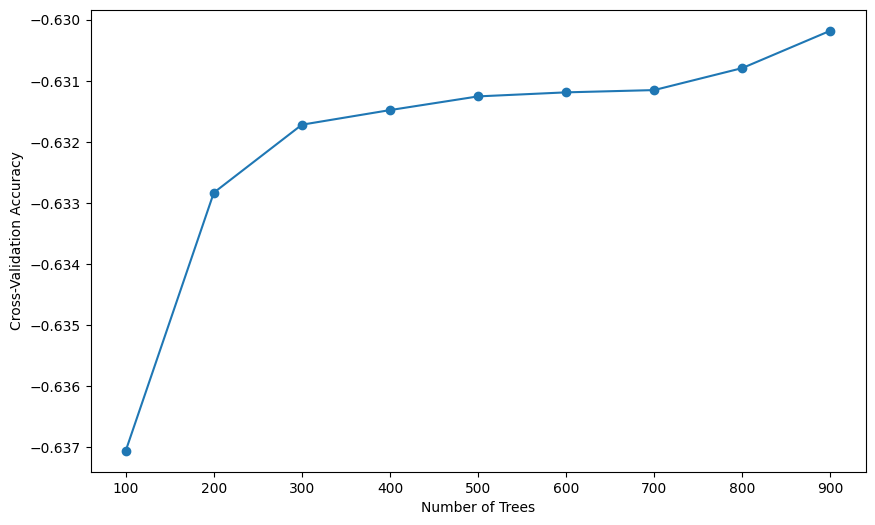

The optimal number of trees is 900


In [16]:
# 设置树的数目范围
n_estimators_range = range(100, 1000, 100)
cv_scores = []

# 使用交叉验证
for n_estimators in n_estimators_range:
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    #scores = cross_val_score(rf, X, y, cv=5, scoring='r2')  # 5折交叉验证
    scores = cross_val_score(rf,X_train, y_train, cv=5, scoring='neg_mean_squared_error')  # 5折交叉验证
    cv_scores.append(scores.mean())

# 绘制交叉验证得分图
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, cv_scores, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Cross-Validation Accuracy')
plt.savefig('target.png')
plt.show()

# 选择最优数量的树
optimal_n_estimators = n_estimators_range[cv_scores.index(max(cv_scores))]
print("The optimal number of trees is {}".format(optimal_n_estimators))

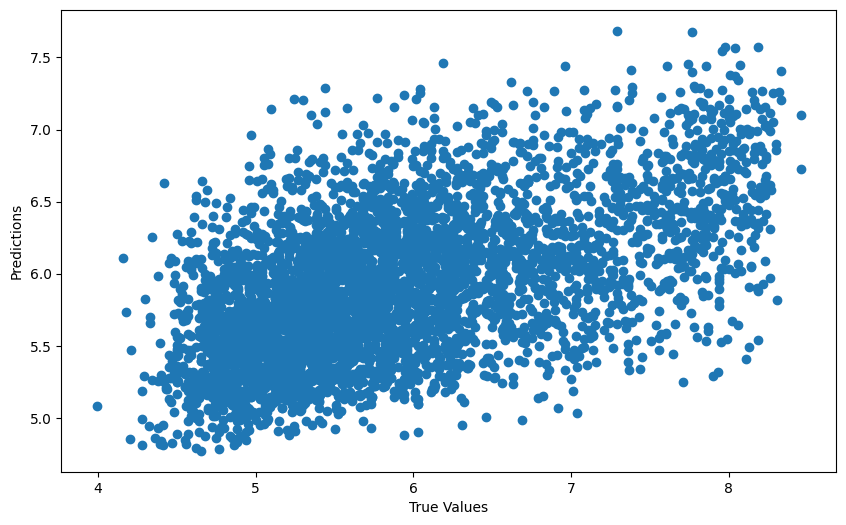

In [30]:
# 初始化和训练随机森林模型
rf = RandomForestRegressor(n_estimators=500, random_state=42,min_samples_leaf=5)
rf.fit(X_train[['pre','tmp','asp','dem','slope','dl']],y_train)

# 在训练数据上预测，并计算残差
rf_predictions_train = rf.predict(X_train[['pre','tmp','asp','dem','slope','dl']])
residuals_train = y_train - rf_predictions_train

# 初始化和训练克里金模型
OK = OrdinaryKriging(X_train['X'], X_train['Y'], residuals_train, variogram_model='linear')

# 在训练数据上进行预测
rf_predictions_test = rf.predict(X_train[['pre','tmp','asp','dem','slope','dl']])
kriging_predictions_train, _ = OK.execute('points', X_train['X'], X_train['Y'])
predictions_train = rf_predictions_test + kriging_predictions_train

# 计算训练集的RMSE,r2
train_rmse = mean_squared_error(y_train, predictions_train, squared=False)
train_r2 = r2_score(y_train,predictions_train)

# 在测试集上进行预测
rf_predictions_test = rf.predict(X_test[['pre','tmp','asp','dem','slope','dl']])
kriging_predictions_test, _ = OK.execute('points', X_test['X'], X_test['Y'])
predictions_test = rf_predictions_test + kriging_predictions_test

# 计算测试集的RMSE,r2
test_rmse = mean_squared_error(y_test, predictions_test, squared=False)
test_r2 = r2_score(y_test,predictions_test)
# 绘制预测值和真实值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_test)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

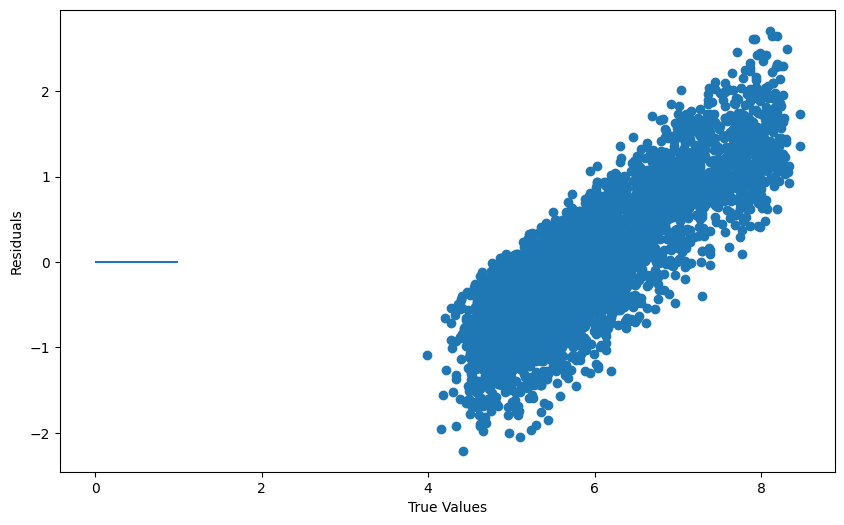

In [31]:
# 绘制测试集的残差图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test - predictions_test)
plt.hlines(y=0, xmin=0, xmax=1)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()

In [19]:
rf.feature_importances_

array([0.18405059, 0.14061276, 0.15023655, 0.31786952, 0.16868777,
       0.0385428 ])

Train RMSE: 0.0023
Train R2: 1.0000
Test RMSE: 0.7780
Test R2: 0.3123


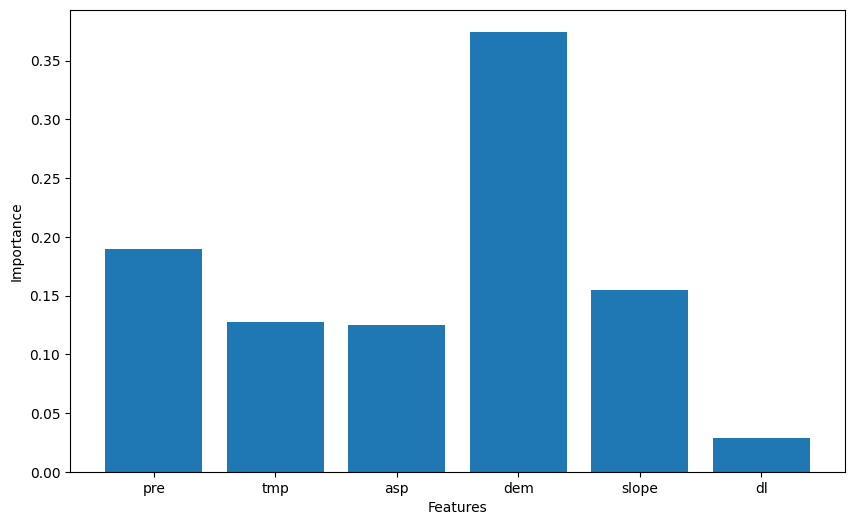

In [32]:
# 打印训练集和测试集的RMSE,r2
print('Train RMSE: %.4f' % train_rmse)
print('Train R2: %.4f' % train_r2)
print('Test RMSE: %.4f' % test_rmse)
print('Test R2: %.4f' % test_r2)
# 绘制特征重要性图
plt.figure(figsize=(10, 6))
plt.bar(['pre','tmp','asp','dem','slope','dl'], rf.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


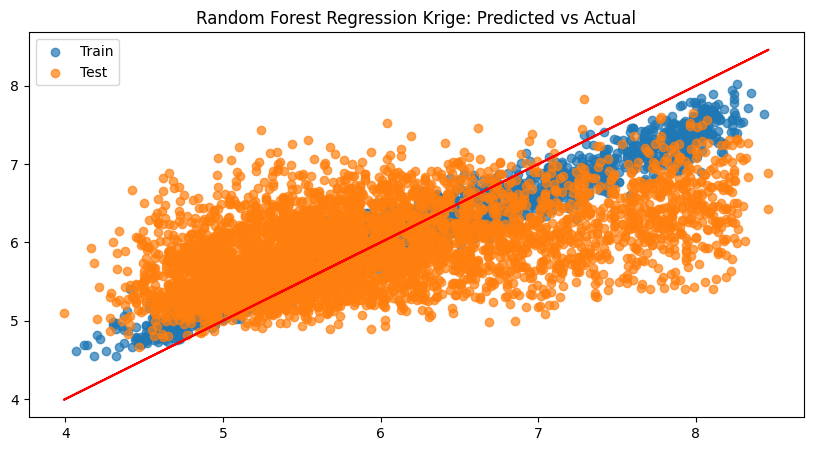

In [28]:
# 在训练集和测试集上的预测值
train_preds = rf.predict(X_train[['pre','tmp','asp','dem','slope','dl']])
test_preds = rf.predict(X_test[['pre','tmp','asp','dem','slope','dl']])


plt.figure(figsize=(10,5))


# 画出训练集的散点图

plt.scatter(y_train, train_preds, label='Train', alpha=.7)

# 画出测试集的散点图

plt.scatter(y_test, test_preds, label='Test', alpha=.7)

# 画出y=x线
plt.plot(y_test, y_test, color='red')



plt.legend()

plt.title('Random Forest Regression Krige: Predicted vs Actual')

plt.show()